In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import pandas as pd
from PIL import Image
import cv2

from typing import List, Dict, Tuple

## Pacal VOC 2007 Dataset load

!curl -L http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar >> VOCtrainval_06-Nov-2007.tar

!ls
!tar -xvf VOCtrainval_06-Nov-2007.tar

In [2]:
_dataset = datasets.VOCDetection(root='./data/VOC/2007/train', year='2007', image_set='train', transform=transforms.ToTensor())

## 이미지 처리
- 이미지 re-size
    - SGD300 모델을 사용하기 위해 (300, 300) size로 이미지 크기 조절
- Bounding box re-size

In [3]:
def imshow(img, norm: bool=False):
    if norm:
        img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    return img

### 1. data로부터 필요한 정보 추출
- image, name, bndbox, image_size

In [4]:
def parse_from_target(data: Tuple) -> Tuple:
    image, target = data
    
    classes: List = []
    bboxes: List = []

    for i in range(len(target['annotation']['object'])):
        bbox: List = []
        _class = target['annotation']['object'][i]['name']
        bndbox = target['annotation']['object'][i]['bndbox']
        width = target['annotation']['size']['width']
        height = target['annotation']['size']['height']
        for key, val in bndbox.items():
            bbox.append(int(val))
        classes.append(_class)
        bboxes.append(bbox)
        
    return image, tuple(classes), tuple(bboxes), (int(width), int(height))

In [5]:
image, classes, bboxes, image_size = parse_from_target(_dataset[17])
classes, bboxes, image_size

(('cat', 'cat'), ([240, 1, 500, 333], [2, 1, 306, 333]), (500, 333))

### 이미지 re-size 함수 정의

In [79]:
import torchvision.transforms.functional as FT

def resize(image, bboxes, image_size, dims: Tuple=(300, 300), return_percent_coords=True):
    width, height = image_size[0], image_size[1]

    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor([width, height, width, height]).unsqueeze(0)
    new_bboxes: List = []
    for bbox in bboxes:
        bbox = torch.tensor(bbox)
        new_box = bbox / old_dims  # percent coordinates
        new_box = new_box.tolist()[0]

        for i, rate in enumerate(new_box):
            if i % 2 == 0:
                new_box[i] = rate * dims[0]
            elif i % 2 == 1:
                new_box[i] = rate * dims[1]
        new_bboxes.append(new_box)
    new_bboxes = torch.tensor(new_bboxes)

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_bboxes: List = []
        for bbox in bboxes:
            bbox = torch.tensor(bbox)
            new_box = bbox * new_dims
            new_bboxes.append(new_box.tolist()[0])
        new_bboxes = torch.tensor(new_bboxes)

    return new_image, new_bboxes

In [80]:
dim = (300, 300)
new_image, new_bboxes = resize(image, bboxes, image_size, dims=dim)
new_image.shape, new_bboxes.shape

(torch.Size([3, 300, 300]), torch.Size([2, 4]))

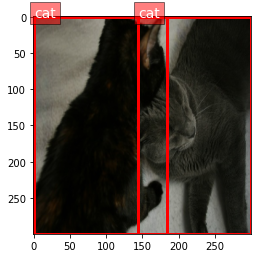

In [81]:
im = imshow(new_image, norm=False)

fig, ax = plt.subplots(1)
ax.imshow(im)
index = 0
for bbox in new_bboxes:
    xmin = bbox[0]
    ymin = bbox[1]
    xmax = bbox[2]
    ymax = bbox[3]

    bbox = patches.Rectangle(xy=(xmin, ymin), width=(xmax-xmin), height=(ymax-ymin), linewidth=3, edgecolor='red', facecolor='none')
    ax.add_patch(bbox)
    ax.text(xmin, ymin, classes[index], size=14, color='white', bbox=dict(facecolor='red', alpha=0.5))
    index += 1

## re-size된 이미지와 바운딩 박스에 대한 데이터셋 load를 위한 클래스 정의

In [158]:
class myDataSet(Dataset):
    def __init__(self, _dataset, dims: Tuple, norm: bool=False):
        super(myDataSet, self).__init__()
        self._dataset = _dataset
        self.dims = dims
        self.norm = norm

    def __len__(self) -> int:
        return len(self._dataset)

    def __getitem__(self, idx: int):
        image, classes, bboxes, image_size = parse_from_target(_dataset[idx])
        new_image, new_bboxes = resize(image, bboxes, image_size, dims=self.dims)
        if self.norm:
            normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            new_image = normalize(new_image)

        return new_image, classes, new_bboxes



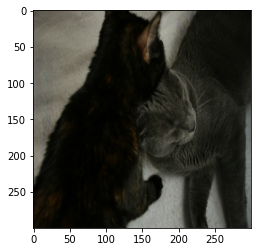

In [159]:
ds = myDataSet(_dataset, (300, 300))
img, _, _ = ds[17]
img = imshow(img, norm=False)
plt.imshow(img)